# [IAPR 2019:][iapr2019] Lab 2 ‒  Object description

**Author:** Jean-Baptiste PROST & Nicolas GANDAR
**Due date:** 19.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [ ]:
import tarfile
import os
import random

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Description
In the `lab-02-data/` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

## 1.1 Data visualization

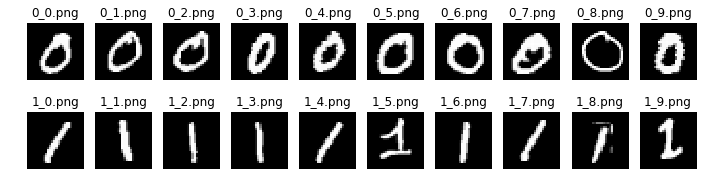

In [2]:
import skimage.io
import skimage.morphology
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from skimage.measure import label, regionprops

%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'

#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### Data cleaning

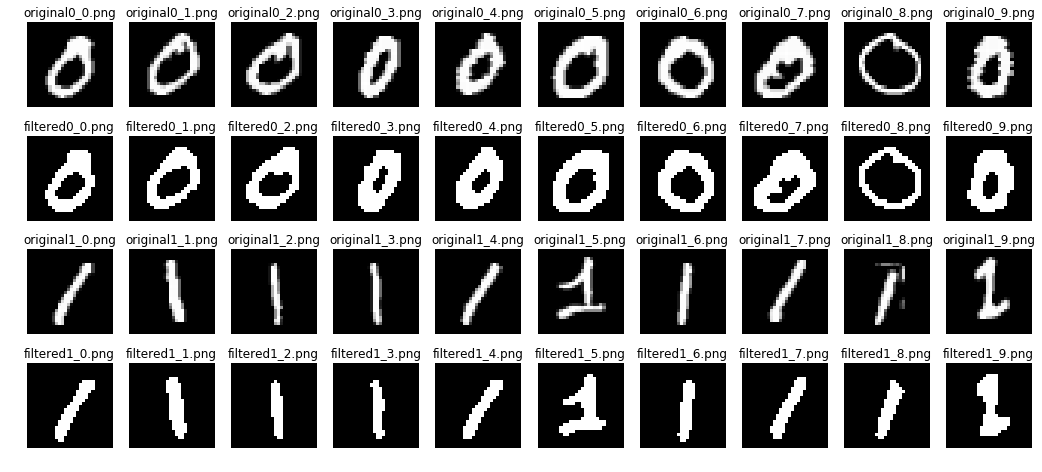

In [4]:
### filtering the images
fig, axes = plt.subplots(4, len(zeros_im), figsize=(18, 8))


### ZEROS
#new list for cleaned images
filtered_zeros_original = []


kernel = np.array([[0, 1, 0],
                   [1, 1, 1],
                   [0, 1, 0]],dtype=np.uint8)


for ax, ax_true, im, nm in zip(axes[1], axes[0], zeros_im, zeros_names):
    #Plotting Initial image
    ax_true.imshow(im, cmap='gray')
    ax_true.axis('off')
    ax_true.set_title("original" + nm)
    ## PreProcessing
    #binarization
    filtered_im = cv2.threshold(im,50,255,cv2.THRESH_BINARY)[1]
    #filtering
    filtered_im = skimage.filters.median(filtered_im, selem=kernel)
    #closing
    filtered_im = skimage.morphology.binary_closing(filtered_im, selem=kernel)
    #plotting
    ax.imshow(filtered_im, cmap='gray')
    ax.axis('off')
    ax.set_title('filtered' + nm)
    filtered_zeros_original.append(np.uint8(filtered_im))

### ONES
kernel = np.array([[0, 1, 1, 0],
                   [1, 1, 1, 1],
                   [0, 1, 1, 0],
                   [0, 1, 1, 0]],dtype=np.uint8)

#new list for cleaned images
filtered_ones_original = []
for ax, ax_true, im, nm in zip(axes[3],axes[2], ones_im, ones_names):
    #Plotting Initial image
    ax_true.imshow(im, cmap='gray')
    ax_true.axis('off')
    ax_true.set_title("original" + nm)
    ## PreProcessin
    #binarization
    filtered_im = cv2.threshold(im,50,255,cv2.THRESH_BINARY)[1]
    #filtering
    filtered_im = skimage.filters.median(filtered_im, selem=kernel)
    #closing
    filtered_im = skimage.morphology.binary_closing(filtered_im, selem=kernel)
    #plotting
    ax.imshow(filtered_im, cmap='gray')
    ax.axis('off')
    ax.set_title('filtered' + nm)
    filtered_ones_original.append(np.uint8(filtered_im))

## 1.2 Fourier descriptors

In [5]:
def findDescriptor(all_images, max_contour_pts= None, nbr=False, normalized=True):
    """
    Takes the images of a digit and returns all fourier's descriptors. Discards 
    the images that have a weak contours detection power.
    
    all_images : list of images
    nbr : boolean to output the number of descriptors
    max_contour_pts : specifies the maximum number of contours points that describe a digit
    normalized : DFT normalized if TRUE
    
    RETURNS:
    fourier_result_list : fourier descritors in list format
    
    fourier_result_stacked : all fourier desciptors stacked into a matrix
    
    images : images that have a contour of at least 30 points.
    
    """
    if normalized:
        norm='ortho'
    else:
        norm=None

    images=all_images.copy()

    contours=[]
    
    #defines a high value to find the smallest nbr of contours points
    if not max_contour_pts:
        max_contour_pts=1e9
    j=0
    for idx, img in enumerate(all_images):

        contour = []
        #get the contours
        contour, hierarchy = cv2.findContours(
            img,
            cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_NONE,
            contour)

        #formating
        contour_array = contour[0][:, 0, :]
        
        #split into imaginary and real part as 2D points
        contour_complex = np.empty(contour_array.shape[:-1], dtype=complex)
        contour_complex.real = contour_array[:, 0]
        contour_complex.imag = contour_array[:, 1]
               
        #finds the min number of contours points amoung images and defines it as the
        #max nbr of points to describe a contour
        nbr_pts_contour=len(contour_complex)
        
        if nbr_pts_contour < 30: #sufficient description of the contour
            images.pop(idx) #remove the image from the list
            print('Image {} removed. Had {} contour points.'.format(idx, nbr_pts_contour))
        
        else:
            contours.append(contour_complex)
        
       
        if (nbr_pts_contour <max_contour_pts) and (nbr_pts_contour > 30):
            max_contour_pts=nbr_pts_contour #find the smallest number of contours points
    

    #initialization
    fourier_result_stacked=np.empty(max_contour_pts)
    fourier_result_list=[]
    
    #samplign the contour points
    for contour_img in contours:
        #generate random indexes to be removed from the contours
        idx_to_remove =random.sample(range(0,len(contour_img)), len(contour_img)-max_contour_pts)
        
        #removes random points so the the all the contours have the same nbr of points
        contour_img=np.delete(contour_img, idx_to_remove, axis=0)
       
        
        #fourier transform
        fourier_tmp=abs(np.fft.fft(contour_img, norm=norm))#
        #fourier_tmp=np.fft.ifftshift(np.fft.fftshift(fourier_tmp))
        fourier_result_list.append(fourier_tmp)
        fourier_result_stacked=np.vstack((fourier_result_stacked,fourier_tmp))

    if nbr:
        print('Images have {} fourier descriptors'.format(fourier_result_stacked.shape[1]))
    
    return fourier_result_list, fourier_result_stacked[1:], images

For every images:
* The contours are retrieved. A list of coodinates defining the shape of the digit is output. <br>

* In oder to be able to compare the images between each other, the number of contour points is monitored. This number is the similar among classes of images (generally around 43 points). <br>An arbitrary threshold is set to 30 points. Under it, the image is considered as too noisy and is discarder from the set. Thsi feature was usefull before the pre-processing (see *Data Cleaning* section). <br> Above the threshold, the number of point can be manually set (`max_contour_pts`) or chosen by findind the images in the class that has the smallest number (41 for Ones and 47 for Zeros).<br> The points are randomly sampled to reach the `max_contour_pts` number of points.<br>  

* A normalized DFT is perfomed (with `numpy.fft` modulus). All fourier desciptors amplitudes are kept for futher analysis. The output format is explicitly redundant to facilite certain uses (plotting, PCA...) 

In [10]:
#Ones
print('--- Ones')
fourier_list_ones, fourier_stack_ones, filtered_ones=findDescriptor(filtered_ones_original, nbr=True)

#Zeros
print('--- Zeros')
fourier_list_z, fourier_stack_z, filtered_zeros=findDescriptor(filtered_zeros_original,max_contour_pts=41,
                                                              nbr=True)

--- Ones
Images have 37 fourier descriptors
--- Zeros
Images have 41 fourier descriptors


In [11]:
def plot_descriptors(descriptors_ones,descriptors_zeros, descriptor1, descriptor2):
    """Scatter plot of descriptor1 vs descriptor2 for every element in the 
    lists of descriptors
    """
    for descriptor in descriptors_zeros:
        plt.scatter(descriptor[descriptor1], descriptor[descriptor2], c='b')
    
    for descriptor in descriptors_ones:
        plt.scatter(descriptor[descriptor1], descriptor[descriptor2], c='r')
        

def compare_descriptors(nb_pairs, fourier_list_ones,fourier_list_z):
    """Grid plot of nb_pairs first pairs of descriptors coupled describing 
    a 2D feature space
    """
    
    plt.figure(figsize=(18,18))
    p=1
    for i in range(nb_pairs):
        for j in range(nb_pairs):

            ax=plt.subplot(nb_pairs,nb_pairs,p)
            plt.title('Descriptors {} vs  {}'.format(i,j), fontweight='bold')

            if p%nb_pairs ==1:
                plt.ylabel('descriptor {} amplitude'.format(i))

            if p >(np.square(nb_pairs)-nb_pairs):
                plt.xlabel('descriptor {} amplitude'.format(j))

            if j==i:
                ax.set_facecolor("lightgray")

            plot_descriptors(fourier_list_ones,fourier_list_z, descriptor1=i, descriptor2=j)

            p+=1

To find the most discriminative paire of descriptors (set of descriptors that creates the most disant clusters between the two classes), a number of descriptors are plotted *versus* each other.

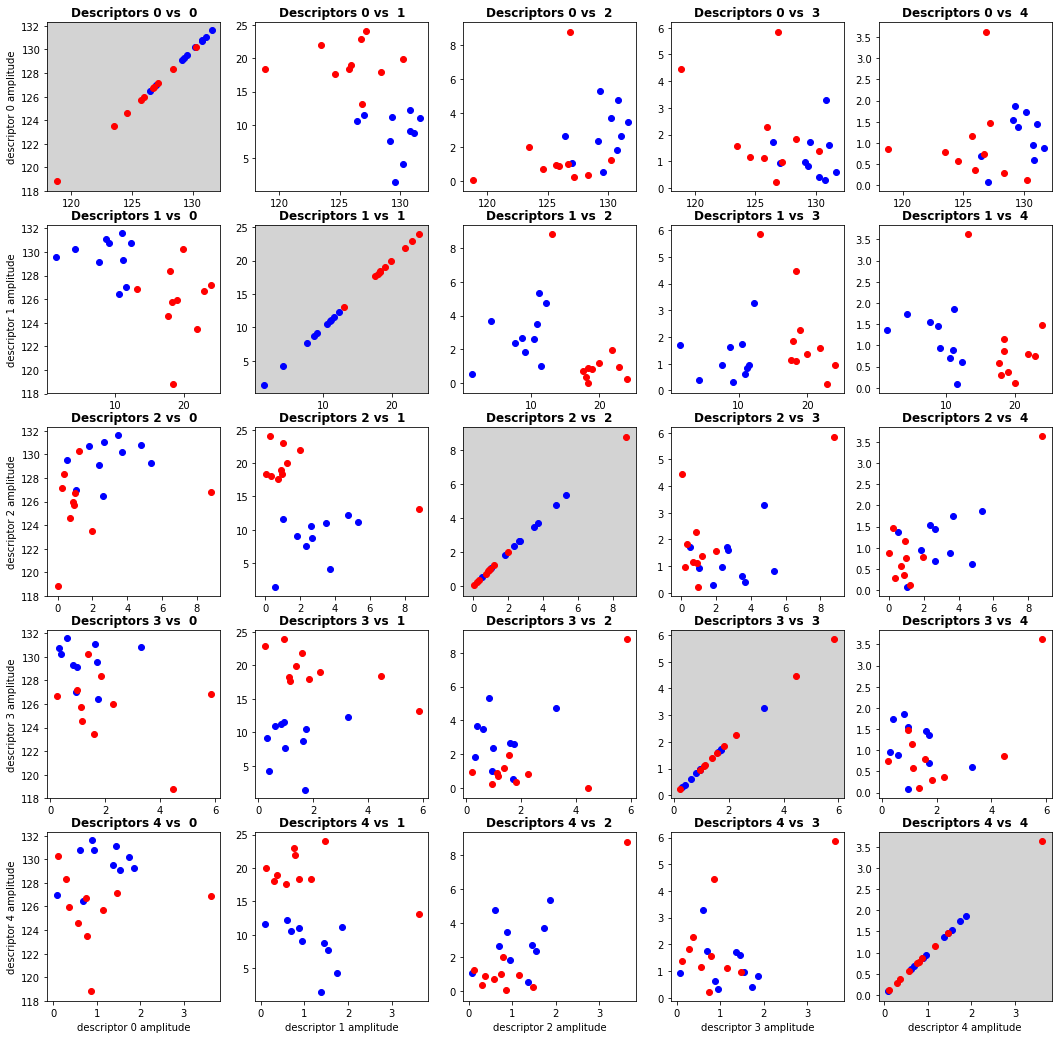

In [12]:
compare_descriptors(5, fourier_list_ones,fourier_list_z)

The <font color='red'>Ones</font> are in <font color='red'>red</font>, the <font color='blue'>Zeros</font> are in <font color='blue'>blue</font>

From the above figure, a satisfying set of descritpors could be descriptors couples (1,2), (1,3) or (1,4). The clusters are distincs eventhough a outlier from the One set is present.


Intrestingly, the first component alone (descriptor1 vs descriptor1) could be a good 1D feature.

### Effect of rotation and scaling
#### Rotation

---------------------------------------- Angle 0° ----------------------------------------
Images have 37 fourier descriptors
Images have 47 fourier descriptors
---------------------------------------- Angle 15° ----------------------------------------
Images have 36 fourier descriptors
Images have 51 fourier descriptors
---------------------------------------- Angle 20° ----------------------------------------
Images have 37 fourier descriptors
Images have 50 fourier descriptors
---------------------------------------- Angle 30° ----------------------------------------
Images have 34 fourier descriptors
Images have 50 fourier descriptors


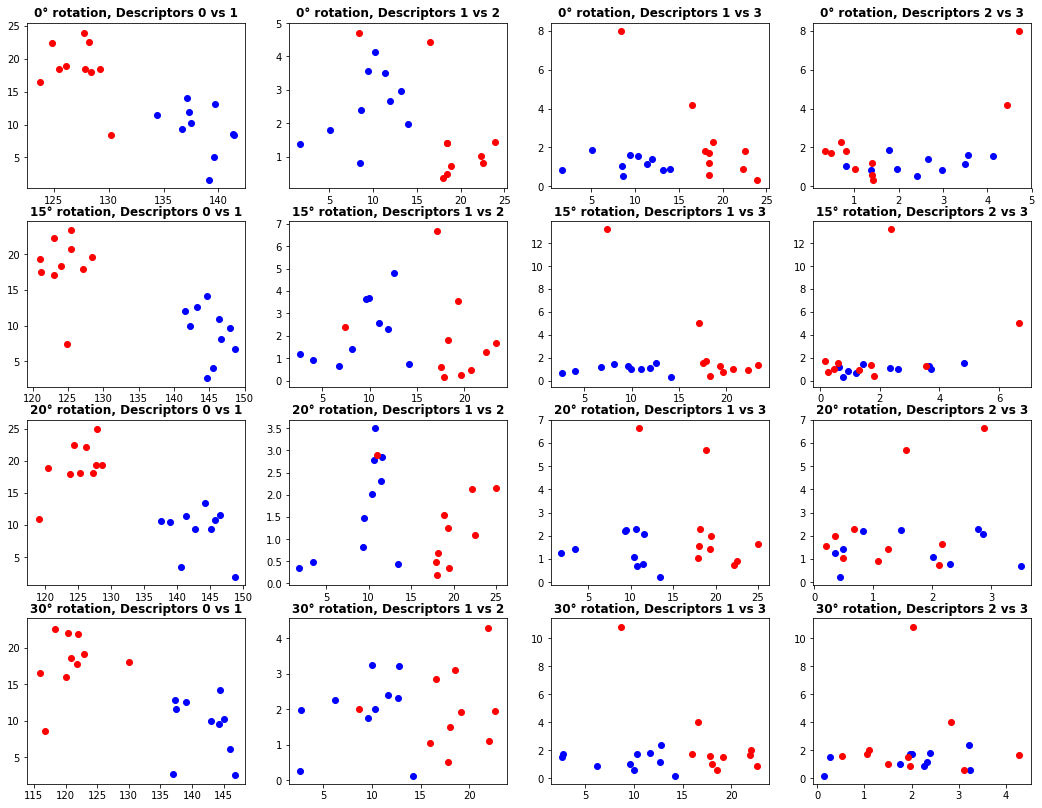

In [13]:
from PIL import Image


normalized=True

plt.figure(figsize=(18,14))
i=1
for angle in [0, 15, 20, 30]:
    print('-'*40 + ' Angle ' +str(angle)+'° ' + '-'*40)


    rotated_ones=[]
    for image in filtered_ones_original:
        im=Image.fromarray(image)
        rot = im.rotate( angle, expand=0 )#.resize(zeros_im[1].shape)
        rotated_ones.append(np.array(rot))
        
    rotated_zeros=[]
    for image in filtered_zeros_original:
        im=Image.fromarray(image)
        rot = im.rotate( angle, expand=0 )#.resize(zeros_im[1].shape)
        rotated_zeros.append(np.array(rot))
        
    #Ones
    fourier_list_ones, _, _=findDescriptor(rotated_ones, nbr=True,normalized=normalized)

    #Zeros
    fourier_list_z, _, _=findDescriptor(rotated_zeros, nbr=True, normalized=normalized )

    plt.subplot(4,4,i)
    plt.title('{}° rotation, Descriptors {} vs {}'.format(angle, 0,1), fontweight="bold")
    plot_descriptors(fourier_list_ones,fourier_list_z, 0,1)
    
    plt.subplot(4,4,i+1)
    plt.title('{}° rotation, Descriptors {} vs {}'.format(angle, 1,2), fontweight="bold")
    plot_descriptors(fourier_list_ones,fourier_list_z, 1,2)
    
    plt.subplot(4,4,i+2)
    plt.title('{}° rotation, Descriptors {} vs {}'.format(angle, 1,3), fontweight="bold")
    plot_descriptors(fourier_list_ones,fourier_list_z, 1,3)
    
    plt.subplot(4,4,i+3)
    plt.title('{}° rotation, Descriptors {} vs {}'.format(angle, 2,3), fontweight="bold")
    plot_descriptors(fourier_list_ones,fourier_list_z, 2,3)
    
    i+=4
        
   

**Discussion**: from the above graphs, the range of desciptors amplitudes stays the same. The clusters are similar no matter the rotation. <br>

Note that the scatter plots are not indentical due to at least two possible reasons:
* the contours is not detected in the same way when the image rotates. This can be seen in the output of the `FindDescriptor` function. The number of fourier descriptors varies with rotations.
* the radom sampling does not discard always the same contours points



### Translation

---------------------------------------- Translation of 0 px to the right ----------------------------------------
Images have 37 fourier descriptors
Images have 47 fourier descriptors
---------------------------------------- Translation of 5 px to the right ----------------------------------------
Images have 37 fourier descriptors
Images have 47 fourier descriptors
---------------------------------------- Translation of 10 px to the right ----------------------------------------
Images have 37 fourier descriptors
Images have 47 fourier descriptors
---------------------------------------- Translation of 15 px to the right ----------------------------------------
Images have 37 fourier descriptors
Images have 47 fourier descriptors


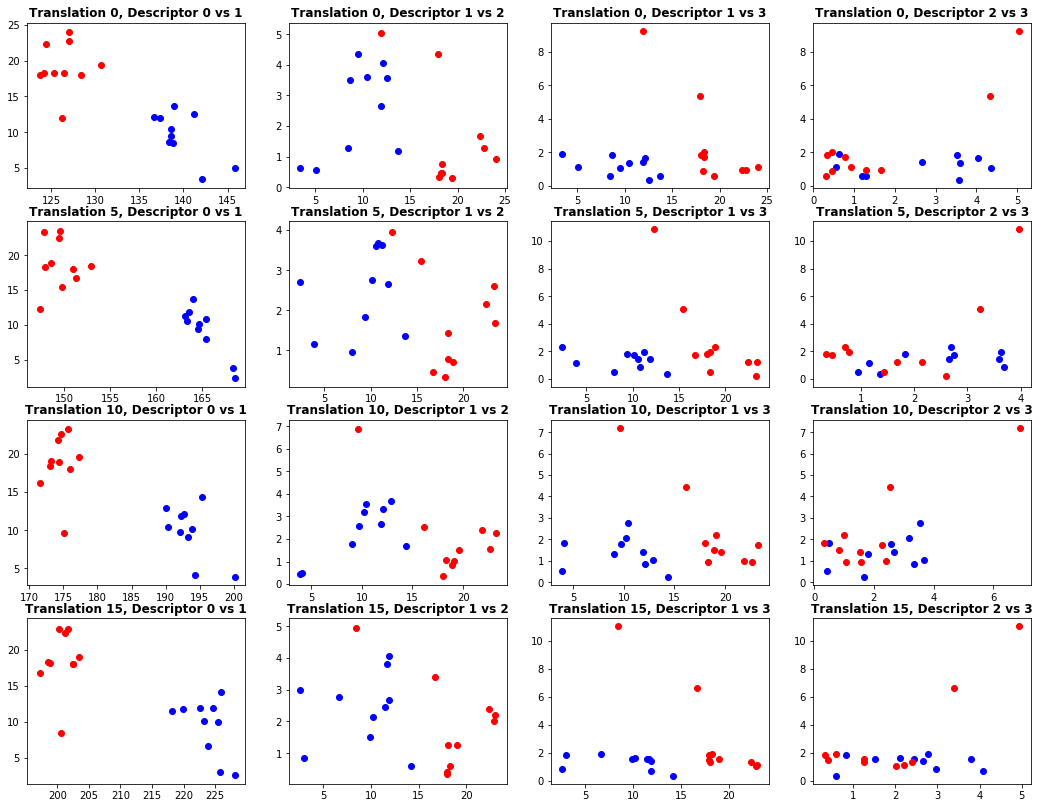

In [14]:
plt.figure(figsize=(18,14))
i=1
for translation in [0, 5, 10, 15]:
    print('-'*40 + ' Translation of ' +str(translation)+' px to the right ' + '-'*40)

    translated_ones=[]
    for image in filtered_ones_original:
        M = np.float32([[1,0,translation],[0,1,0]])
        trans = cv2.warpAffine(image,M,(58,28))
        translated_ones.append(trans)
        
    translated_zeros=[]
    for image in filtered_zeros_original:
        M = np.float32([[1,0,translation],[0,1,0]])
        trans = cv2.warpAffine(image,M,(58,28))
        translated_zeros.append(trans)
        
    #Ones
    fourier_list_ones, _, _=findDescriptor(translated_ones, nbr=True)

    #Zeros
    fourier_list_z, _, _=findDescriptor(translated_zeros, nbr=True)

    plt.subplot(4,4,i)
    plt.title('Translation {}, Descriptor {} vs {}'.format(translation, 0,1), fontweight='bold')
    plot_descriptors(fourier_list_ones,fourier_list_z, 0,1)
    
    plt.subplot(4,4,i+1)
    plt.title('Translation {}, Descriptor {} vs {}'.format(translation, 1,2), fontweight='bold')
    plot_descriptors(fourier_list_ones,fourier_list_z, 1,2)
    
    plt.subplot(4,4,i+2)
    plt.title('Translation {}, Descriptor {} vs {}'.format(translation, 1,3), fontweight='bold')
    plot_descriptors(fourier_list_ones,fourier_list_z, 1,3)
    
    plt.subplot(4,4,i+3)
    plt.title('Translation {}, Descriptor {} vs {}'.format(translation, 2,3), fontweight='bold')
    plot_descriptors(fourier_list_ones,fourier_list_z, 2,3)
    
    i+=4
        
   

The translation affect only the zero descriptor : the max value of the X axis almost doubled from 0 translation to 15 px translation. The other descriptors still have the same range (but some variation ax explained above).

### PCA

The *Principal Component Analysis* enables to create a new space (defines by principal components -- PC) build upon a linear combinaison of the original features (here the fourier desciptors). The new space is made such that the first PCs maximises the variance of the data, *i.e* the first PC will gather most of the variance, the second a significant part, the third a non negligeable percentage ... until the last PC that represent only the small variantions of the data.

Hence, by creating a new space, once can retrieve only the first 2 PCs (thus reducing the space to 2 dimentions) and still gather most of the variance in the data. Hopefully, this variance will be the element that will enable to distinguish the two classes (inter-classes) and not the variance intra-classes (variantion among the classes)


In our study, all the fourier descriptors (of both classes) are stacked togehter such that an every image has the same number $X$ of fourier descriptors. The $X$ dimensional feature space will undergo a PCA. Onlyt he first two PCs will be retrieved.

In [16]:
#Ones
print('--- Ones ---')
_, fourier_stack_ones, _=findDescriptor(filtered_ones_original, nbr=True)
print('{} images remaining \n'.format(fourier_stack_ones.shape[0]))

#Zeros
print('---  Zeros  ---')
_, fourier_stack_z, _=findDescriptor(filtered_zeros_original,37, nbr=True)
print('{} images remaining'.format(fourier_stack_z.shape[0]))

--- Ones ---
Images have 37 fourier descriptors
10 images remaining 

---  Zeros  ---
Images have 37 fourier descriptors
10 images remaining


In [17]:
#gather all fourier descriptors, keeping only the first 37 for zeros
all_fourier=np.vstack((fourier_stack_ones[:,:fourier_stack_ones.shape[1]],\
                       fourier_stack_z[:,:fourier_stack_ones.shape[1]]))

In [18]:
from sklearn.decomposition import PCA

pca=PCA(n_components=2)

#creates the PC space
features=pca.fit_transform(all_fourier)
ratio=pca.explained_variance_ratio_
print('The variance obatained for the first two components are {} % and {} %'.format(np.round(100*ratio[0],2),
                                                                                     np.round(100*ratio[1],2)))
print('The first two PCs represent {} % of the total data variance.'.format(np.round(100*(ratio[0]+ratio[1]),2)))

The variance obatained for the first two components are 83.15 % and 7.65 %
The first two PCs represent 90.8 % of the total data variance.


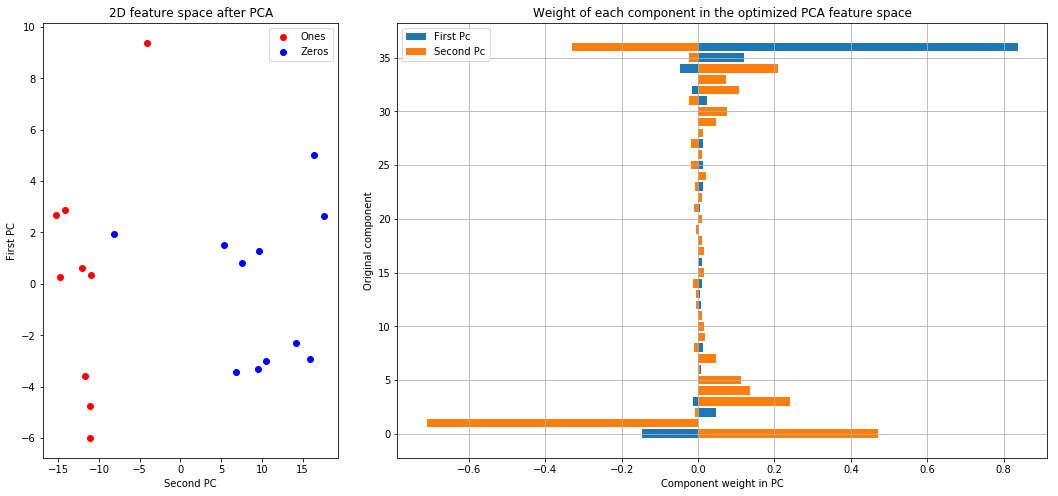

In [19]:
plt.figure(figsize=(18,8))
plt.subplot(1,3,1)
plt.scatter(features[:9,0], features[:9,1], color='r', label='Ones')
plt.scatter(features[9:,0], features[9:,1], color='b', label='Zeros')
plt.title('2D feature space after PCA')
plt.ylabel('First PC')
plt.xlabel('Second PC')
plt.legend()

plt.subplot(1,3,(2,3))
plt.barh(y=np.arange(0, pca.components_.shape[1]), width=pca.components_[0,:], label='First Pc' )
plt.barh(y=np.arange(0, pca.components_.shape[1]), width=pca.components_[1,:], label='Second Pc' )
plt.ylabel('Original component')
plt.xlabel('Component weight in PC')
plt.title('Weight of each component in the optimized PCA feature space')
plt.legend()
plt.grid()
plt.show()

From the left figure, we cen observe a clear gap between the two clusters. The gap is mainly defined on the vertical axis that is the firs PC as it represent 88% of the variance in the data set. The zero fourier descriptor (as mentioned above) is enough to distinguish between two classes. Note that the first PC is mainly defined by the first component but also (mostly) by the second, the penultimate and the last descriptor (right plot)

The last components have a significant weight on the first two PCs eventhough they represent the high frequency variantion in the contour.

**Conclusion** <br>

The best feature space is obtained thanks to the PCA. The first component might be enough to discriminate the images. However, as mentioned previously, the zero descriptor (main contributor of the first PC) is sensitive to translation.

## 1.3 Additional method(s)

### Compacity


Compacity is defined as $C = \frac{P^2}{A}$

In [20]:
def calculate_compacity(images):
    C_images = []
    for im in images:
        regions = regionprops(im.astype('int'))
        C_images.append((regions[0].perimeter**2)/regions[0].area)
        
    return C_images

#We start by calculating the compacity for each picture
C_ones = calculate_compacity(filtered_ones_original)
C_zeros = calculate_compacity(filtered_zeros_original)


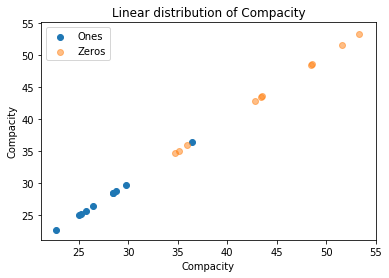

In [21]:
def plot_compacity(list_ones, list_zeros, lab1, lab0, label):
    plt.scatter(list_ones, list_ones, label=lab1)
    plt.scatter(list_zeros, list_zeros, label=lab0, alpha=0.5)
    plt.xlabel(label)
    plt.ylabel(label)
    tit = 'Linear distribution of ' + label
    plt.title(tit)
    plt.legend()
    plt.show()
    
plot_compacity(C_ones, C_zeros, "Ones", "Zeros", 'Compacity')


Compacity is invariant by rotation and translation as we only care about the Area and the Perimeter, which are themselves invariant by rotation and translation. <br>
The resulting distribution separates quite well the ones from the zeros. However, while the ones a well clustered in the bottomg left, the zeros are more spread out and do not form a clear cluster.

Let's see how KMeans would perform

In [22]:
def create_X_Y(ones, zeros):
    '''
    Creates a two D array from lists, where x1 = x2
    '''
    X = np.concatenate((np.asarray([ones, ones]).T, np.asarray([zeros, zeros]).T))
    y = np.concatenate((np.ones((len(ones), 1)),np.zeros((len(zeros), 1))))
    return X,y


In [23]:
from sklearn.cluster import KMeans

def perform_kmean(X,y, descriptor, rstate):
    '''
    Performs KMean clustering and return list where "True" means this image was missclassfied
    '''
    kmeans = KMeans(n_clusters=2, random_state=rstate).fit(X)
    kmeans.labels_ = 1 - kmeans.labels_ 
    print("------------------- KMeans on", descriptor ,"clusters-------------------")
    print("Total Accuracy:", 100*np.sum(kmeans.labels_ == y.T)/len(y), "%")
    print("Missclassified points:", np.sum(kmeans.labels_ != y.T))
    
    return kmeans.labels_ != y.T

In [24]:
X,y = create_X_Y(C_ones, C_zeros)
compacity_error = perform_kmean(X,y, 'Compacity', 1)

------------------- KMeans on Compacity clusters-------------------
Total Accuracy: 85.0 %
Missclassified points: 3


Let's see which images are problematic, it is probably the 3 zeros with a compacity below 40

In [25]:
def plot_wrong_im(error, original_ones, original_zeros):

    error_arg = np.argwhere(error)
    for i in range(len(error_arg)):
        if error_arg[i][1] < 10:
            plt.imshow(original_ones[error_arg[i][1]])
        else:
            plt.imshow(original_zeros[error_arg[i][1]-10])
        plt.show()


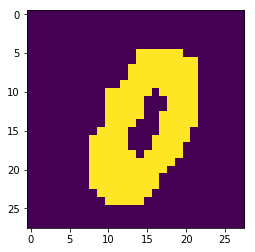

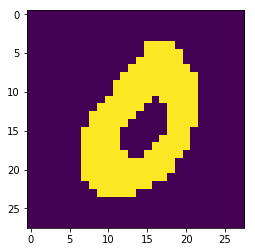

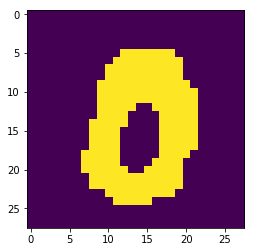

In [26]:
plot_wrong_im(compacity_error, filtered_ones_original, filtered_zeros_original)

Without surprise, the problematic zeroes are the more narrow ones

### Elongation

Elongation is the ration between maximum diameter and its minimum diameter perpendicular to it. It should work nicely for ones and zeros.<br>
It can also be defined as the square root of the ratio of the eigenvalues of the matrix of inertia

In [27]:
def create_regions(images):
    '''
    returns regio props of images
    '''
    C_images = []
    for im in images:
        C_images.append(regionprops(im.astype('int'))[0])
    return C_images

regio_ones = create_regions(filtered_ones_original)
regio_zeros = create_regions(filtered_zeros_original)

zero_ratio = []
one_ratio = []

#Using the second definition of elongation
for zero, one in zip(regio_zeros, regio_ones):
    one_ratio.append(np.sqrt(one.inertia_tensor_eigvals[0]/one.inertia_tensor_eigvals[1]))
    zero_ratio.append(np.sqrt(zero.inertia_tensor_eigvals[0]/zero.inertia_tensor_eigvals[1]))


/Users/Jean-BaptistePROST/miniconda3/envs/TF/lib/python3.7/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/Users/Jean-BaptistePROST/miniconda3/envs/TF/lib/python3.7/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


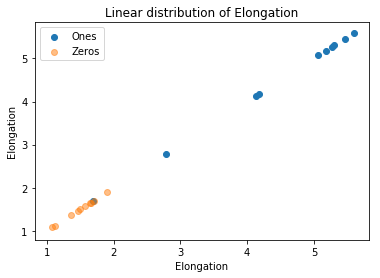

In [28]:
plot_compacity(one_ratio, zero_ratio, "Ones", "Zeros", "Elongation")

Elongation is invariant by translation and invariance, the separation works quite well but again, the ones are very spread out.

Testing KMeans performance

In [29]:
X,y = create_X_Y(one_ratio, zero_ratio)
elongation_error = perform_kmean(X,y, 'Elongation', 2)

------------------- KMeans on Elongation clusters-------------------
Total Accuracy: 90.0 %
Missclassified points: 2


KMeans performs similarly on elongation clusters than compacity clusters

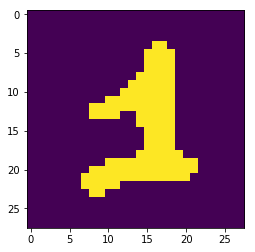

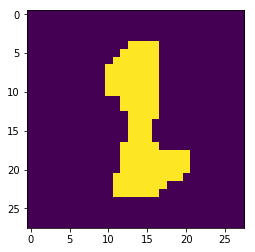

In [30]:
plot_wrong_im(elongation_error, filtered_ones_original, filtered_zeros_original)

This time, the two different ones are misclassified

### Projections

Projecting the pixel count on the x and y axis. $P_{x,y} = \sum_{i,j} f(i,y)$

In [31]:
def project(images):
    '''
    Projects pixel count on axis
    '''
    C_images = []
    for im in images:
        C_images.append(np.append(im.sum(axis=0), im.sum(axis=1)))
    return C_images

#We know have 56 dimension points (each x,y has 28 pixels)
projection_ones = project(filtered_ones_original)
projection_zeroes = project(filtered_zeros_original)


In [32]:
X = np.concatenate((np.asarray(projection_ones), np.asarray(projection_zeroes)))
proj_error = perform_kmean(X,y, 'Projection', 1)

------------------- KMeans on Projection clusters-------------------
Total Accuracy: 95.0 %
Missclassified points: 1


The clustering works better, but we are in high dimension

Here are the missclassified images

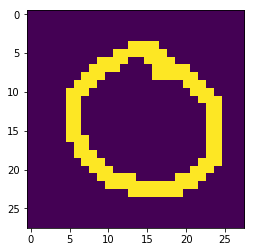

In [33]:
plot_wrong_im(proj_error, filtered_ones_original, filtered_zeros_original)

Only the thinner zero is missclassified

Let's have a look at the first two principale components with PCA

In [34]:
#creates the PC space

features=pca.fit_transform(X)
ratio=pca.explained_variance_ratio_
print('The variance obatained for the first two components are {} % and {} %'.format(np.round(100*ratio[0],2),
                                                                                     np.round(100*ratio[1],2)))
print('The first two PCs represent {} % of the total data variance.'.format(np.round(100*(ratio[0]+ratio[1]),2)))

The variance obatained for the first two components are 64.29 % and 12.17 %
The first two PCs represent 76.45 % of the total data variance.


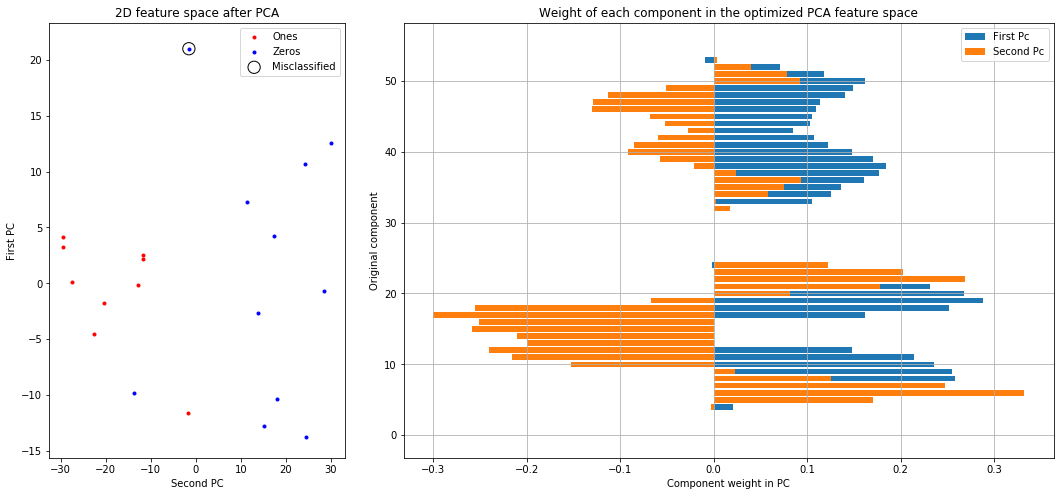

In [35]:
plt.figure(figsize=(18,8))
plt.subplot(1,3,1)
plt.scatter(features[:9,0], features[:9,1], color='r', label='Ones', marker='.')
plt.scatter(features[9:,0], features[9:,1], color='b', label='Zeros', marker='.')

#Misclassified points
for err in np.argwhere(proj_error):
    plt.scatter(features[err[1],0], features[err[1],1], s=150, facecolors='none', \
                edgecolors='k', label='Misclassified')

plt.title('2D feature space after PCA')
plt.ylabel('First PC')
plt.xlabel('Second PC')
plt.legend()

plt.subplot(1,3,(2,3))
plt.barh(y=np.arange(0, pca.components_.shape[1]), width=pca.components_[0,:], label='First Pc' )
plt.barh(y=np.arange(0, pca.components_.shape[1]), width=pca.components_[1,:], label='Second Pc' )
plt.ylabel('Original component')
plt.xlabel('Component weight in PC')
plt.title('Weight of each component in the optimized PCA feature space')
plt.legend()
plt.grid()
plt.show()

KMeans is performed in higher dimension and then projected in 2D, hence the 2D clusters do not 